In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2
import seaborn as sb

In [2]:
dir_out = 'plots/'
dir_data_out = 'outputs/'

In [3]:
# read the big table
# if this file does not exist you should generate it by running code in this folder: SVs
file_name = 'outputs/test.tsv'
df = pd.read_table(file_name, sep='\t', header=0)

/scratch/smmortazavi/job_40638765/ipykernel_3362936/640373490.py:4: DtypeWarning: Columns (25,70,72,73,77,78,79,80,81,82,83,84,88,99,100,101,102,103,104,105,106,110,111,112,113,114,115,116,117,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0)


In [4]:
def get_df_flt(df, flt_name, svtypes, ext_col=None, flt_sd_art=True, freq_col=None, freq_thr=None):
    df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0) | (df['NUM_IL_GT_SAMPLES'] > 0) | (df['NUM_SV2_GT_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes))]
    #| (df['NUM_SV2_GT_SAMPLES'] > 0)
    if flt_sd_art:
        df_flt = df_flt.loc[~((df_flt.SD_ART==1) & (df_flt.PLATFORM=='LR'))]
    if freq_thr != None:
        df_flt = df_flt.loc[df_flt[f'freq_{freq_col}']<=freq_thr]
    return df_flt

plots//filter_calls_freq1.png


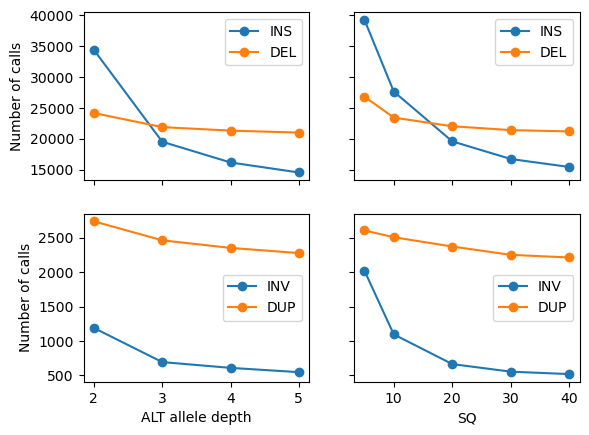

plots//filter_calls_total_freq1.png


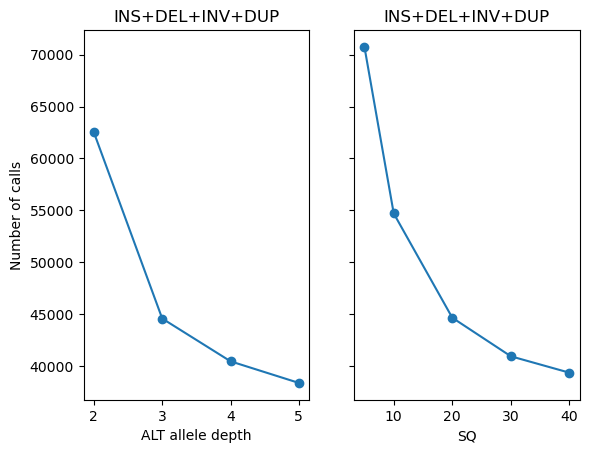

In [5]:
##############################
### plot filtering AD, SQ
##############################
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
freq_thr = 1
freq_col = 'AD2_SAMPLES'

ads = [2, 3, 4, 5]
qs = [5, 10, 20, 30, 40]
sv_counts_ad = []
sv_counts_q = []
for ad in ads:
    #print(f'++++++++++++ AD{ad} filter ++++++++++')
    flt_name = f'AD{ad}_SAMPLES'
    this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
    this_counts = this_df.SVTYPE.value_counts()
    this_counts['INS'] = this_counts['INS'] + this_counts['.']
    sv_counts_ad.append(this_counts)
    
for q in qs:
    #print(f'++++++++++++ SQ{q} filter ++++++++++')
    flt_name = f'SQ{q}_SAMPLES'
    this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
    this_counts = this_df.SVTYPE.value_counts()
    this_counts['INS'] = this_counts['INS'] + this_counts['.']
    sv_counts_q.append(this_counts)

###########################
fig, axs = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col')
svtypes_1 = ['INS', 'DEL']
svtypes_2 = ['INV', 'DUP']
for svtype in svtypes_1:
    axs[0, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_1:
    axs[0, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)

axs[1, 0].set_xlabel('ALT allele depth')
axs[1, 1].set_xlabel('SQ')
axs[0, 0].set_ylabel('Number of calls')
axs[1, 0].set_ylabel('Number of calls')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

fig_name = f'{dir_out}/filter_calls_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

svtypes = ['INS', 'DEL', 'INV', 'DUP']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax1.plot(ads, [x[svtypes].sum() for x in sv_counts_ad], '-o')
ax2.plot(qs, [x[svtypes].sum() for x in sv_counts_q], '-o')
ax1.set_xlabel('ALT allele depth')
ax2.set_xlabel('SQ')
ax1.set_ylabel('Number of calls')
ax1.set_title('+'.join(svtypes))
ax2.set_title('+'.join(svtypes))
fig_name = f'{dir_out}/filter_calls_total_freq{freq_thr}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [6]:
def venn_(set1only, set2only, set1and2, labels_list, fig_name, title, FS=8):
    plt.figure(figsize=(2, 2))
    v = venn2(subsets=(set1only, set2only, set1and2),
          set_labels=(labels_list[0], labels_list[1]), set_colors=('skyblue', 'lightgreen'))
    v.get_label_by_id('10').set_fontsize(FS)
    v.get_label_by_id('01').set_fontsize(FS)
    v.get_label_by_id('11').set_fontsize(FS)
    plt.title(title)
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
    #plt.savefig(fig_name[:-4]+'.pdf', bbox_inches='tight', dpi=1200)
    plt.show()
    plt.close()

def hist(df, fig_name='out.png', log_scale=(True, True), bins='auto', palette=sb.color_palette(), sv_set={'DEL', 'DUP', 'INS', 'INV'},
        title='', hue=None, FS=8):
    plt.figure(figsize=(2, 1.5))
    df_plot = df.loc[df.SVTYPE.isin(sv_set)]
    df_plot = df_plot.loc[df_plot.SVLEN <= 1e6]
    sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False, 
                bins=bins, palette=palette, linewidth=2)
    plt.xlabel('SV length', fontsize=FS)
    plt.xticks(fontsize=FS)
    plt.yticks(fontsize=FS)
    plt.title(title)
    plt.xlim(right=1e6)
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight', dpi=1200)
    #plt.savefig(fig_name[:-4]+'.pdf', bbox_inches='tight', dpi=1200)
    plt.show()
    plt.close()

In [7]:
### how many SQ20 SVs and DEL, INS, DUP, INV:
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
freq_thr = 1
freq_col = 'AD2_SAMPLES'
q = 20
flt_name = f'SQ{q}_SAMPLES'
this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
this_counts = this_df.SVTYPE.value_counts()
this_counts['INS'] = this_counts['INS'] + this_counts['.']
print('here INS include "." counts as well. so use that number for insertions:')
display(this_counts)

###
tot_svs = this_counts[['DEL', 'INS', 'DUP', 'INV']].sum()
print(f'total SVs (DEL+INS+DUP+INV): {tot_svs}')

###
this_counts = this_df.PLATFORM_CV.value_counts()
display(this_counts)

here INS include "." counts as well. so use that number for insertions:


SVTYPE
DEL    22033
INS    19579
.       2770
DUP     2370
INV      665
Name: count, dtype: int64

total SVs (DEL+INS+DUP+INV): 44647


PLATFORM_CV
LR_IL    21075
LR       16488
IL        7084
Name: count, dtype: int64

In [8]:
cols_clean_mini = ['CHROM', 'POS', 'END', 'ID', 'SVTYPE', 'PLATFORM_CV', 'SVLEN', 'SRC', 'GENCODE',
                   'MAT_INH_LR', 'PAT_INH_LR', 
                   'MAT_INH_IL', 'PAT_INH_IL', 'AC', 'freq_AD2_SAMPLES', 'PASS_STRICT', 'TR50', 'SD50', 
                   'Consequence','SYMBOL', 'GENE',
                   'GENES_PLI', 'MAX_PLI', 'MAX_PLI_GENE', 'GENES_LOEUF', 'MIN_LOEUF', 'MIN_LOEUF_GENE', 
                   'GENES_FDR_ASD', 'MIN_FDR_ASD', 'MIN_FDR_ASD_GENE', 'GENES_FDR_DD', 'MIN_FDR_DD', 'MIN_FDR_DD_GENE', 
                   'GENES_FDR_NDD', 'MIN_FDR_NDD', 'MIN_FDR_NDD_GENE', 
                   'SQ20_SAMPLES', 
                   'AD2_SAMPLES', 
                   'SV2_GT_SAMPLES', 'IL_SAMPLES_LR', 'IL_GT_SAMPLES_LR', 
                   'HET_SAMPLES', 'HOMALT_SAMPLES']

cols_need_case_mini = ['SQ20_SAMPLES', 
                       'AD2_SAMPLES',
                       'SV2_GT_SAMPLES', 'IL_SAMPLES', 'IL_GT_SAMPLES',
                       'HET_SAMPLES', 'HOMALT_SAMPLES']
cols_case_mini = [f'case_{x}' for x in cols_need_case_mini]
# augment clean columns by cases
cols_clean_mini = cols_clean_mini + cols_case_mini

total: (344746, 434)
filtered: (44647, 434)
df_flt_table: (44647, 434)
outputs//table_SVs_SQ20_SAMPLES_freq1.tsv
df_flt_len: (41877, 434)


/scratch/smmortazavi/job_40638765/ipykernel_3362936/344172694.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False,


plots//hist_svlen_allSVs_SQ20_SAMPLES_freq1_noPlat.png


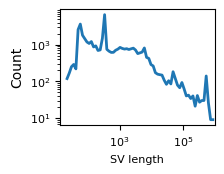

plots//IL_vs_LR_venn_allSVs_SQ20_SAMPLES_freq1.png


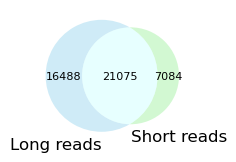

plots//IL_vs_LR_venn_ins_SQ20_SAMPLES_freq1.png


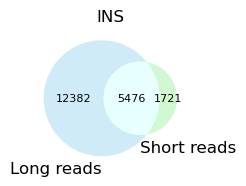

plots//IL_vs_LR_venn_del_SQ20_SAMPLES_freq1.png


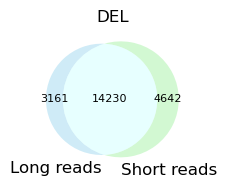

plots//IL_vs_LR_venn_dup_SQ20_SAMPLES_freq1.png


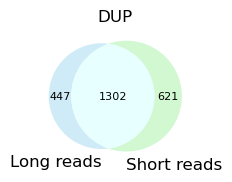

plots//IL_vs_LR_venn_inv_SQ20_SAMPLES_freq1.png


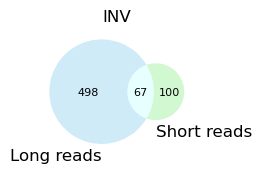

In [9]:
##########################################
### platform discovery rate
##########################################
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
freq_col = 'AD2_SAMPLES'

title_add = f''

############# All variants ##############
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

### make a talbe of calls:
df_flt_table = df_flt.copy()
print(f'df_flt_table: {df_flt_table.shape}')
### make a column for coding and coding_constrained
gen_list = ['CDS', 'start_codon', 'stop_codon']
df_flt_table['coding'] = df_flt_table.apply(lambda row: 'TRUE' if row.GENCODE in gen_list else 'FALSE', axis=1)
df_flt_table['coding_constrained'] = df_flt_table.apply(lambda row: 'TRUE' if (row.coding=='TRUE') and 
                                                        ((row.X_PLIp9==1) or (row.X_LOEUF==1) or (row.X_FDR_ASD==1) or 
                                                         (row.X_FDR_DD==1) or (row.X_FDR_NDD==1)) else 'FALSE', axis=1)
col_extra = ['coding', 'coding_constrained']
table_name =  f'{dir_data_out}/table_SVs_{flt_name}_freq{freq_thr}.tsv'
print(table_name)
df_flt_table[cols_clean_mini+col_extra].to_csv(table_name, sep='\t', header=True, index=False)

df_flt_len = df_flt.loc[df_flt.SVTYPE!='.'].copy()
df_flt_len['SVLEN'] = df_flt_len['SVLEN'].astype(int).abs()
print(f'df_flt_len: {df_flt_len.shape}')
fig_name = f'{dir_out}/hist_svlen_allSVs_{flt_name}_freq{freq_thr}_noPlat.png'
palette = {'LR': 'skyblue', 'IL':'lightgreen', 'LR_IL':'paleturquoise'}
hist(df_flt_len, fig_name, palette=palette, title=title_add)

IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='.')].shape[0]
IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DEL')].shape[0]
IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DUP')].shape[0]
IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='INV')].shape[0]
IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='BND')].shape[0]
IL_total = IL_ins + IL_del + IL_dup + IL_inv
#print(f'IL_ins: {IL_ins}')
#print(f'IL_del: {IL_del}')
#print(f'IL_dup: {IL_dup}')
#print(f'IL_inv: {IL_inv}')
#print(f'IL_bnd: {IL_bnd}')

LR_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INS')].shape[0]
LR_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DEL')].shape[0]
LR_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DUP')].shape[0]
LR_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INV')].shape[0]
LR_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='BND')].shape[0]
LR_total = LR_ins + LR_del + LR_dup + LR_inv
#print(f'LR_ins: {LR_ins}')
#print(f'LR_del: {LR_del}')
#print(f'LR_dup: {LR_dup}')
#print(f'LR_inv: {LR_inv}')
#print(f'LR_bnd: {LR_bnd}')

LR_IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & ((df_flt.SVTYPE=='INS') | (df_flt.SVTYPE=='.'))].shape[0]
LR_IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DEL')].shape[0]
LR_IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DUP')].shape[0]
LR_IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INV')].shape[0]
LR_IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='BND')].shape[0]
LR_IL_total = LR_IL_ins + LR_IL_del + LR_IL_dup + LR_IL_inv
#print(f'LR_IL_ins: {LR_IL_ins}')
#print(f'LR_IL_del: {LR_IL_del}')
#print(f'LR_IL_dup: {LR_IL_dup}')
#print(f'LR_IL_inv: {LR_IL_inv}')
#print(f'LR_IL_bnd: {LR_IL_bnd}')

venn_(LR_total, IL_total, LR_IL_total, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_allSVs_{flt_name}_freq{freq_thr}.png', title=''+title_add)
venn_(LR_ins, IL_ins, LR_IL_ins, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_ins_{flt_name}_freq{freq_thr}.png', title='INS'+title_add)
venn_(LR_del, IL_del, LR_IL_del, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_del_{flt_name}_freq{freq_thr}.png', title='DEL'+title_add)
venn_(LR_dup, IL_dup, LR_IL_dup, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_dup_{flt_name}_freq{freq_thr}.png', title='DUP'+title_add)
venn_(LR_inv, IL_inv, LR_IL_inv, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_inv_{flt_name}_freq{freq_thr}.png', title='INV'+title_add)

total: (344746, 434)
filtered: (44647, 434)
df_flt_table: (1243, 434)
outputs//table_SVs_coding_SQ20_SAMPLES_freq1.tsv
df_flt_len: (1239, 434)
plots//hist_svlen_allSVs_coding_SQ20_SAMPLES_freq1_noPlat.png


/scratch/smmortazavi/job_40638765/ipykernel_3362936/344172694.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False,


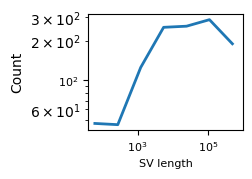

plots//IL_vs_LR_venn_allSVs_coding_SQ20_SAMPLES_freq1.png


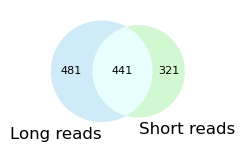

plots//IL_vs_LR_venn_ins_coding_SQ20_SAMPLES_freq1.png


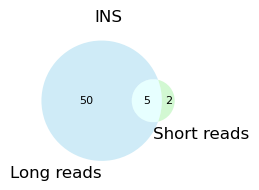

plots//IL_vs_LR_venn_del_coding_SQ20_SAMPLES_freq1.png


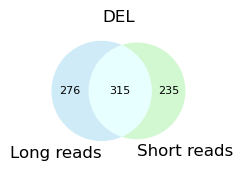

plots//IL_vs_LR_venn_dup_coding_SQ20_SAMPLES_freq1.png


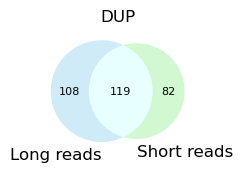

plots//IL_vs_LR_venn_inv_coding_SQ20_SAMPLES_freq1.png


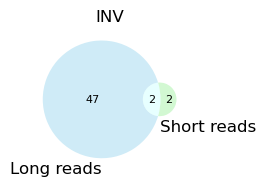

In [10]:
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
freq_col = 'AD2_SAMPLES'

title_add = f''

############# Coding variants ##############
gen_list = ['CDS', 'start_codon', 'stop_codon']
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

### make a talbe of calls:
df_flt_table = df_flt.loc[df_flt.GENCODE.isin(gen_list)].copy()
print(f'df_flt_table: {df_flt_table.shape}')
### make a column for coding and coding_constrained
df_flt_table['coding'] = df_flt_table.apply(lambda row: 'TRUE' if row.GENCODE in gen_list else 'FALSE', axis=1)
df_flt_table['coding_constrained'] = df_flt_table.apply(lambda row: 'TRUE' if (row.coding=='TRUE') and 
                                                        ((row.X_PLIp9==1) or (row.X_LOEUF==1) or (row.X_FDR_ASD==1) or 
                                                         (row.X_FDR_DD==1) or (row.X_FDR_NDD==1)) else 'FALSE', axis=1)
col_extra = ['coding', 'coding_constrained']
table_name =  f'{dir_data_out}/table_SVs_coding_{flt_name}_freq{freq_thr}.tsv'
print(table_name)
df_flt_table[cols_clean_mini+col_extra].to_csv(table_name, sep='\t', header=True, index=False)

df_flt_len = df_flt.loc[(df_flt.GENCODE.isin(gen_list)) & (df_flt.SVTYPE!='.')].copy()
df_flt_len['SVLEN'] = df_flt_len['SVLEN'].astype(int).abs()
print(f'df_flt_len: {df_flt_len.shape}')
fig_name = f'{dir_out}/hist_svlen_allSVs_coding_{flt_name}_freq{freq_thr}_noPlat.png'
palette = {'LR': 'skyblue', 'IL':'lightgreen', 'LR_IL':'paleturquoise'}
bins = 7
hist(df_flt_len, fig_name, palette=palette, title=title_add, bins=bins)

IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='.') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list))].shape[0]
IL_total = IL_ins + IL_del + IL_dup + IL_inv
#print(f'IL_ins: {IL_ins}')
#print(f'IL_del: {IL_del}')
#print(f'IL_dup: {IL_dup}')
#print(f'IL_inv: {IL_inv}')
#print(f'IL_bnd: {IL_bnd}')

LR_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INS') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_total = LR_ins + LR_del + LR_dup + LR_inv
#print(f'LR_ins: {LR_ins}')
#print(f'LR_del: {LR_del}')
#print(f'LR_dup: {LR_dup}')
#print(f'LR_inv: {LR_inv}')
#print(f'LR_bnd: {LR_bnd}')

LR_IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & ((df_flt.SVTYPE=='INS') | (df_flt.SVTYPE=='.')) & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list))].shape[0]
LR_IL_total = LR_IL_ins + LR_IL_del + LR_IL_dup + LR_IL_inv
#print(f'LR_IL_ins: {LR_IL_ins}')
#print(f'LR_IL_del: {LR_IL_del}')
#print(f'LR_IL_dup: {LR_IL_dup}')
#print(f'LR_IL_inv: {LR_IL_inv}')
#print(f'LR_IL_bnd: {LR_IL_bnd}')

venn_(LR_total, IL_total, LR_IL_total, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_allSVs_coding_{flt_name}_freq{freq_thr}.png', title=''+title_add)
venn_(LR_ins, IL_ins, LR_IL_ins, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_ins_coding_{flt_name}_freq{freq_thr}.png', title='INS'+title_add)
venn_(LR_del, IL_del, LR_IL_del, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_del_coding_{flt_name}_freq{freq_thr}.png', title='DEL'+title_add)
venn_(LR_dup, IL_dup, LR_IL_dup, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_dup_coding_{flt_name}_freq{freq_thr}.png', title='DUP'+title_add)
venn_(LR_inv, IL_inv, LR_IL_inv, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_inv_coding_{flt_name}_freq{freq_thr}.png', title='INV'+title_add)

total: (344746, 434)
filtered: (44647, 435)
df_flt_table: (143, 435)
outputs//table_SVs_coding_constrained_SQ20_SAMPLES_freq1.tsv
df_flt_len: (143, 435)
plots//hist_svlen_allSVs_coding_constrained_SQ20_SAMPLES_freq1_noPlat.png


/scratch/smmortazavi/job_40638765/ipykernel_3362936/344172694.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sb.histplot(data=df_plot, x='SVLEN', hue=hue, element="poly", log_scale=log_scale, fill=False,


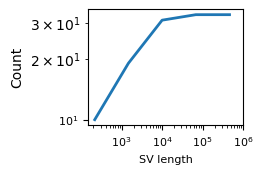

plots//IL_vs_LR_venn_allSVs_coding_constraint_SQ20_SAMPLES_freq1.png


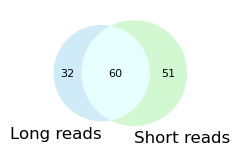

plots//IL_vs_LR_venn_ins_coding_constraint_SQ20_SAMPLES_freq1.png


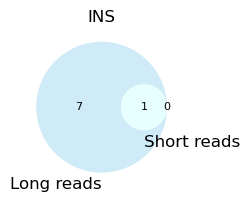

plots//IL_vs_LR_venn_del_coding_constraint_SQ20_SAMPLES_freq1.png


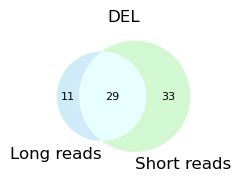

plots//IL_vs_LR_venn_dup_coding_constraint_SQ20_SAMPLES_freq1.png


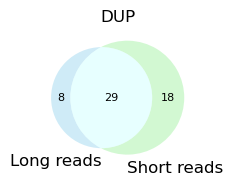

plots//IL_vs_LR_venn_inv_coding_constraint_SQ20_SAMPLES_freq1.png


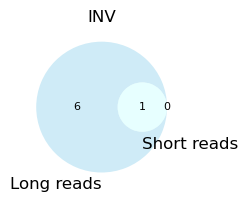

In [11]:
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
freq_col = 'AD2_SAMPLES'

title_add = f''

############# Coding constrained variants ##############
gen_list = ['CDS', 'start_codon', 'stop_codon']
# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
df_flt['constrained'] = df_flt.apply(lambda row: 1 if ((row.X_PLIp9==1) or (row.X_LOEUF==1) or 
                                                       (row.X_FDR_ASD==1) or (row.X_FDR_DD==1) or (row.X_FDR_NDD==1)) else 0, axis=1)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

### make a talbe of calls:
df_flt_table = df_flt.loc[(df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].copy()
print(f'df_flt_table: {df_flt_table.shape}')
### make a column for coding and coding_constrained
df_flt_table['coding'] = df_flt_table.apply(lambda row: 'TRUE' if row.GENCODE in gen_list else 'FALSE', axis=1)
df_flt_table['coding_constrained'] = df_flt_table.apply(lambda row: 'TRUE' if (row.coding=='TRUE') and 
                                                        ((row.X_PLIp9==1) or (row.X_LOEUF==1) or (row.X_FDR_ASD==1) or 
                                                         (row.X_FDR_DD==1) or (row.X_FDR_NDD==1)) else 'FALSE', axis=1)
col_extra = ['coding', 'coding_constrained']
table_name =  f'{dir_data_out}/table_SVs_coding_constrained_{flt_name}_freq{freq_thr}.tsv'
print(table_name)
df_flt_table[cols_clean_mini+col_extra].to_csv(table_name, sep='\t', header=True, index=False)

df_flt_len = df_flt.loc[(df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1) & (df_flt.SVTYPE!='.')].copy()
df_flt_len['SVLEN'] = df_flt_len['SVLEN'].astype(int).abs()
print(f'df_flt_len: {df_flt_len.shape}')
fig_name = f'{dir_out}/hist_svlen_allSVs_coding_constrained_{flt_name}_freq{freq_thr}_noPlat.png'
palette = {'LR': 'skyblue', 'IL':'lightgreen', 'LR_IL':'paleturquoise'}
bins = 5
hist(df_flt_len, fig_name, palette=palette, title=title_add, bins=bins)

IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='.') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
IL_total = IL_ins + IL_del + IL_dup + IL_inv
#print(f'IL_ins: {IL_ins}')
#print(f'IL_del: {IL_del}')
#print(f'IL_dup: {IL_dup}')
#print(f'IL_inv: {IL_inv}')
#print(f'IL_bnd: {IL_bnd}')

LR_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INS') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_total = LR_ins + LR_del + LR_dup + LR_inv
#print(f'LR_ins: {LR_ins}')
#print(f'LR_del: {LR_del}')
#print(f'LR_dup: {LR_dup}')
#print(f'LR_inv: {LR_inv}')
#print(f'LR_bnd: {LR_bnd}')

LR_IL_ins = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & ((df_flt.SVTYPE=='INS') | (df_flt.SVTYPE=='.')) & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_del = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DEL') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_dup = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='DUP') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_inv = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='INV') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_bnd = df_flt.loc[(df_flt.PLATFORM_CV=='LR_IL') & (df_flt.SVTYPE=='BND') & (df_flt.GENCODE.isin(gen_list)) & (df_flt.constrained==1)].shape[0]
LR_IL_total = LR_IL_ins + LR_IL_del + LR_IL_dup + LR_IL_inv
#print(f'LR_IL_ins: {LR_IL_ins}')
#print(f'LR_IL_del: {LR_IL_del}')
#print(f'LR_IL_dup: {LR_IL_dup}')
#print(f'LR_IL_inv: {LR_IL_inv}')
#print(f'LR_IL_bnd: {LR_IL_bnd}')

venn_(LR_total, IL_total, LR_IL_total, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_allSVs_coding_constraint_{flt_name}_freq{freq_thr}.png', title=''+title_add)
venn_(LR_ins, IL_ins, LR_IL_ins, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_ins_coding_constraint_{flt_name}_freq{freq_thr}.png', title='INS'+title_add)
venn_(LR_del, IL_del, LR_IL_del, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_del_coding_constraint_{flt_name}_freq{freq_thr}.png', title='DEL'+title_add)
venn_(LR_dup, IL_dup, LR_IL_dup, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_dup_coding_constraint_{flt_name}_freq{freq_thr}.png', title='DUP'+title_add)
venn_(LR_inv, IL_inv, LR_IL_inv, ['Long reads', 'Short reads'], f'{dir_out}/IL_vs_LR_venn_inv_coding_constraint_{flt_name}_freq{freq_thr}.png', title='INV'+title_add)

In [12]:
# psam data for all the REACH cohort
file_psam_all = '../data/REACH.2022_01_07.psam'
df_p = pd.read_table(file_psam_all, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_p.sample_id, df_p.dad, df_p.mom):
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

,famid,sample_id,dad,mom,sex,phen
0,AUTPGX_4,1004,3004,2004,1,2
1,AUTPGX_5,1005,3005,2005,1,2
2,AUTPGX_8,1008,3008,2008,1,2
3,AUTPGX_14,1014,3014,2014,1,2
4,AUTPGX_18,1018,3018,2018,1,2
...,...,...,...,...,...,...
1127,V5T5W,V5T5W_04,0,0,1,0
1128,X3N7Y,X3N7Y_01,X3N7Y_04,X3N7Y_03,1,2
1129,X3N7Y,X3N7Y_03,0,0,2,0
1130,X3N7Y,X3N7Y_04,0,0,1,0


In [13]:
file_psam_lr = '../data/REACH_LR_platform.psam'
df_p_lr = pd.read_table(file_psam_lr, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
df_p_lr['sample_id'] = df_p_lr.apply(lambda row: row['sample_id'].rstrip('_PB').rstrip('_ONT').rstrip('_IL'), axis=1)
df_p_lr['dad'] = df_p_lr.apply(lambda row: row['dad'].rstrip('_PB').rstrip('_ONT').rstrip('_IL'), axis=1)
df_p_lr['mom'] = df_p_lr.apply(lambda row: row['mom'].rstrip('_PB').rstrip('_ONT').rstrip('_IL'), axis=1)
display(df_p_lr)

print('complete trios:')
df_trios = df_p_lr.loc[df_p_lr.dad.isin(df_p_lr.sample_id) & df_p_lr.mom.isin(df_p_lr.sample_id)]
display(df_trios)

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


In [14]:
meta_file = '../data/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)
df_meta.set_index('Sample_ID', inplace=True)
display(df_meta)

,Subject_ID,Family_ID,DOB,Family_Type,Affected,Diagnosis_LAB,Mother_ID,Father_ID,Rel_Proband,Chrono_Age (months),...,Date sent for DNA extraction,Location of DNA extraction,DNA Box,Concentration (ng/uL),260/280,Date sent for Sequencing,WGS Provider,(Sample Well) Plate Name.Sample.ID,Affected_orig,Affected_ASD
Sample_ID,,,,,,,,,,,,,,,,,,,,,
REACH000001,F0001-01,F0001,3/26/2007,trio,Yes,Autism,F0001-02,F0001-03,Proband,46,...,Unknown,Gleeson,1,60.0,1.80,9/9/2013,Illumina,LP6005688-DNA_E11,Yes,Yes
REACH000107,F0001-02,F0001,8/9/1972,trio,Yes,Autism,Unknown,Unknown,Mom,475,...,Unknown,Gleeson,2,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_F11,Yes,Yes
REACH000226,F0001-03,F0001,9/27/1969,trio,Yes,"Autism, PTSD, ADHD",Unknown,Unknown,Dad,523,...,Unknown,Gleeson,3,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_G11,Yes,Yes
REACH000002,F0002-01,F0002,11/19/2007,incomplete,Yes,Autism,Unknown,Unknown,Proband,38,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
REACH000003,F0003-01,F0003,8/9/2000,incomplete,Yes,Autism,Unknown,Unknown,Proband,126,...,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
REACH000889,F0320-02,F0320,1/15/1981,multiple,No,"Crohn's Disease, Lupus (SLE)",F8888-88,F8888-88,Mom,431,...,2/28/2017,Sebat,11,36.2,1.79,pending,pending,pending,No,No
REACH000890,F0320-03,F0320,7/9/1980,multiple,No,NaN,F8888-88,F8888-88,Dad,437,...,2/28/2017,Sebat,11,41.9,1.84,pending,pending,pending,No,No
REACH000891,F0320-04,F0320,2/26/2010,multiple,No,NaN,F0320-02,F0320-03,Sibling,81,...,2/28/2017,Sebat,11,119.7,1.84,pending,pending,pending,No,No


In [15]:
file_pca = '../data/master_phen_4.SBayesR.20210915.csv'
df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]
print(f'df_pca size: {df_pca.shape[0]}')

# only look at REACH samples
df_pca_flt = df_pca.loc[df_pca.iid.str.contains('REACH')].copy()
df_pca_flt['rel'] = 'C'
print(f'REACH, df_pca_flt size: {df_pca_flt.shape[0]}')
#display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

df_parents['rel'] = 'P'
print(f'REACH, df_parents size: {df_parents.shape[0]}')

# merge children and parents
df_pca_flt = pd.concat([df_pca_flt, df_parents])
print(f'REACH, children + parents size: {df_pca_flt.shape[0]}')

# Add Race column
df_pca_flt['Race'] = df_pca_flt['iid'].map(df_meta['Race'])
display(df_pca_flt)

df_pca_flt_lr = df_pca_flt.loc[df_pca_flt.iid.isin(df_trios.sample_id.tolist()+df_trios.mom.tolist()+df_trios.dad.tolist())]
print(f'REACH LR, children + parents size: {df_pca_flt_lr.shape[0]}')

df_pca size: 17460
REACH, df_pca_flt size: 281
REACH, df_parents size: 309
REACH, children + parents size: 590


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel,Race
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C,White
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C,Other
138,F0050,REACH000050,ASD,Male,1,trio,1.0,1,-0.007029,0.022216,...,0.004346,-0.024711,-0.008170,-0.018570,0.001443,0.002810,-0.000927,-0.001673,C,White
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C,White
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0291,REACH000769,.,Male,1,.,NaN,0,0.086006,-0.003008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,Other
0,F0162C,REACH000775,.,Female,1,.,NaN,1,-0.006961,0.001684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,White
0,F0162C,REACH000776,.,Male,1,.,NaN,1,-0.011109,0.010559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,White
0,F0162B,REACH000772,.,Female,1,.,NaN,1,-0.015162,0.008165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P,White


REACH LR, children + parents size: 243


plots//REACH_SSC_SPARK_PC1_vs_PC2.png


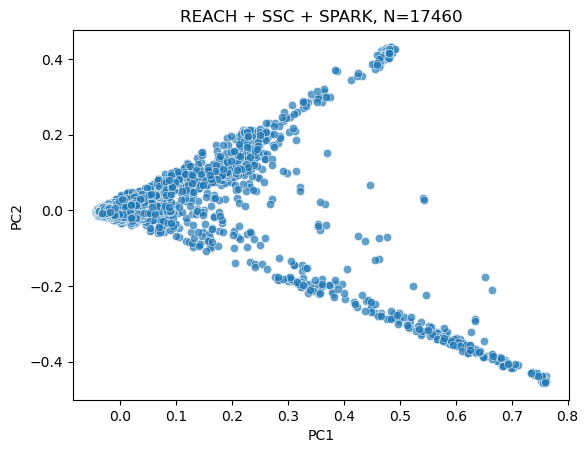

plots//REACH_ALL_PC1_vs_PC2.png


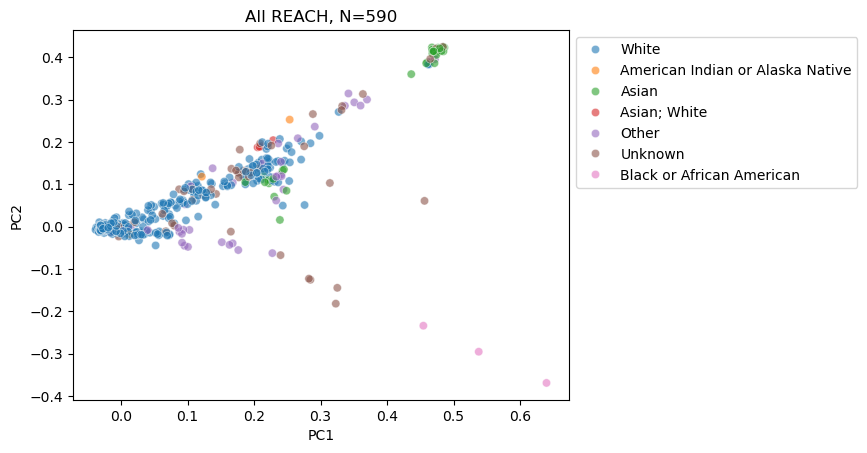

plots//REACH_LR_PC1_vs_PC2.png


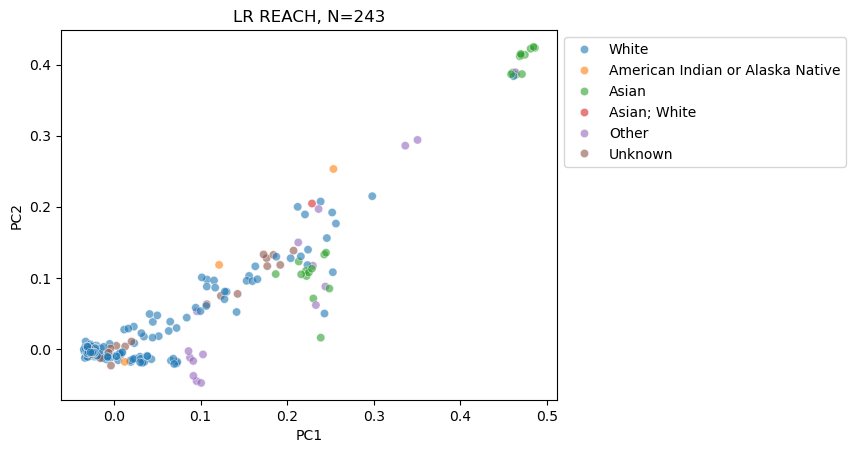

In [16]:
import seaborn as sb

hue_order = ['White', 'American Indian or Alaska Native', 'Asian', 'Asian; White', 'Other', 'Unknown', 'Black or African American']

plt.figure()
sb.scatterplot(data=df_pca, x='PC1', y='PC2', alpha = .7)
plt.title(f'REACH + SSC + SPARK, N={df_pca.shape[0]}')
fig_name = f'{dir_out}/REACH_SSC_SPARK_PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_pca_flt, x='PC1', y='PC2', hue='Race', hue_order=hue_order, alpha = .6)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title(f'All REACH, N={df_pca_flt.shape[0]}')
fig_name = f'{dir_out}/REACH_ALL_PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

plt.figure()
sb.scatterplot(data=df_pca_flt_lr, x='PC1', y='PC2', hue='Race', hue_order=hue_order[:-1], alpha = .6)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.title(f'LR REACH, N={df_pca_flt_lr.shape[0]}')
fig_name = f'{dir_out}/REACH_LR_PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344746, 434)
filtered: (44647, 434)
sample_counts_svs:


samples
REACH000226       7323
REACH000236_PB    7268
REACH000427       7120
REACH000543       7063
REACH000428       7010
                  ... 
REACH000532_PB     858
REACH000688        740
REACH000768        470
REACH000751        440
2323-2-1            76
Name: count, Length: 282, dtype: int64

df_svs_trs:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,SAMPLE,MEAN_COVERAGE,Phenotype,Phenotype_ASD,Platform,SNV_CAR,count_BP50_SUPP2_genomewide,count_BP50_SUPP3_genomewide,SV_counts,total_SV_counts_TR_SUPP2
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,REACH000001,10.15,1,1,ONT,0,10965,9214,6393.0,17358.0
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,REACH000026,3.22,1,1,HiFi,1,398,329,5058.0,5456.0
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,REACH000058,6.19,1,1,HiFi,1,6448,5528,6242.0,12690.0
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,REACH000065,1.22,1,1,HiFi,1,117,62,3138.0,3255.0
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,REACH000086,2.70,1,1,HiFi,0,2242,1295,4686.0,6928.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,REACH000756,1.55,0,0,HiFi,0,1165,564,3446.0,4611.0
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,REACH000763,3.36,0,0,HiFi,0,3871,2641,4786.0,8657.0
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,REACH000764,1.20,0,0,HiFi,0,887,391,2978.0,3865.0
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,REACH000768,0.10,0,0,HiFi,0,4,1,470.0,474.0


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,SAMPLE,MEAN_COVERAGE,Phenotype,Phenotype_ASD,Platform,SNV_CAR,count_BP50_SUPP2_genomewide,count_BP50_SUPP3_genomewide,SV_counts,total_SV_counts_TR_SUPP2
118,F0001,REACH000226,.,Male,1,.,NaN,1,0.024023,-0.013482,...,REACH000226,29.45,1,1,ONT,0,11562,11286,7323.0,18885.0


plots//num_nonTR_SVs_vs_cov.png


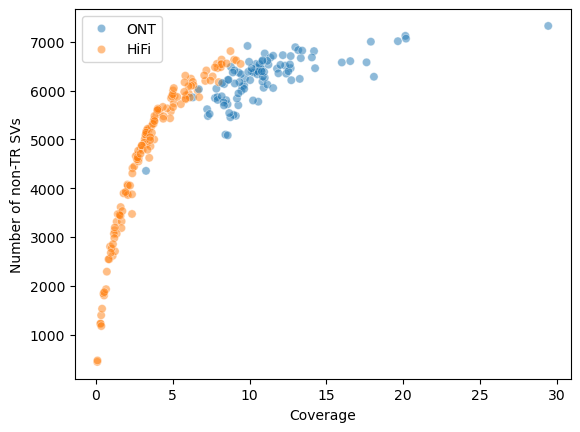

plots//num_TR_SVs_vs_cov_BP50_SUPP2.png


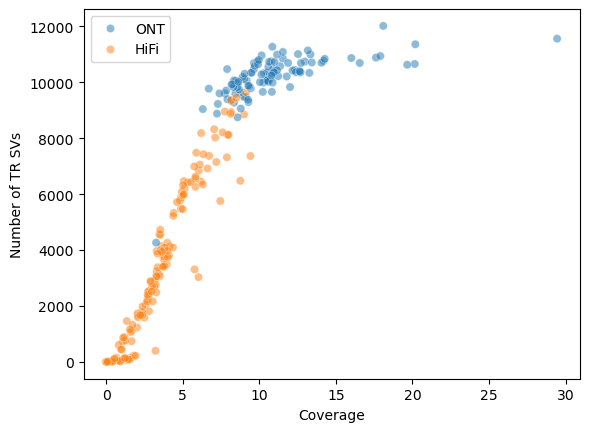

plots//num_total_SVs_vs_cov_BP50_SUPP2.png


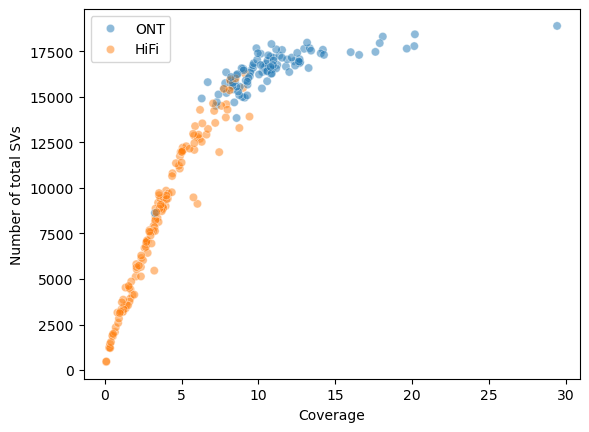

In [17]:
### plot number of SVs and TRs for each sample as a function of coverage
# non-TR SVs:
flt_name = 'SQ20_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

freq_thr=1
freq_col = 'AD2_SAMPLES'

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

samples_list = [y for xs in df_flt[flt_name].str.split(',').tolist() for y in xs if y != '.']
df_samples = pd.DataFrame({'samples': samples_list})
sample_counts_svs = df_samples.samples.value_counts()
print('sample_counts_svs:')
display(sample_counts_svs)

# TR SVs:
### if this file does not exist you should generate it using code in folder: TRs
file_name = '../TRs/outputs/num_TR_SVs_vs_cov.tsv'
df_svs_trs = pd.read_table(file_name, sep='\t', header=0)
df_svs_trs['Platform'] = df_svs_trs['Platform'].map({'PB': 'HiFi', 'ONT': 'ONT'})

# augment non-TR SVs to TR SVs:
col_new = 'SV_counts'
df_svs_trs[col_new] = df_svs_trs.SAMPLE.map(sample_counts_svs)

# add non-tr and tr SVs
supp_thrs = [2]
bp_thr = 50
for supp_thr in supp_thrs:
    col_trs = f'count_BP{bp_thr}_SUPP{supp_thr}_genomewide'
    col_new = f'total_SV_counts_TR_SUPP{supp_thr}'
    df_svs_trs[col_new] = df_svs_trs.SV_counts + df_svs_trs[col_trs]
print('df_svs_trs:')
display(df_svs_trs)

### display the large coverage sample:
display(df_svs_trs.loc[df_svs_trs.MEAN_COVERAGE>25])

# plot number of SVs/TRs vs coverage
# SVs
col_count = 'SV_counts'
plt.figure()
ax = sb.scatterplot(data=df_svs_trs, x='MEAN_COVERAGE', y=col_count, hue='Platform', alpha=.5)
ax.get_legend().set_title("")
plt.xlabel('Coverage')
plt.ylabel('Number of non-TR SVs')
#plt.title(f'bp dev ≥ {bp_thr}, read supp ≥ {supp_thr}')
fig_name = f'{dir_out}/num_nonTR_SVs_vs_cov.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()
# TRs
for supp_thr in supp_thrs:
    col_count = f'count_BP{bp_thr}_SUPP{supp_thr}_genomewide'
    plt.figure()
    ax = sb.scatterplot(data=df_svs_trs, x='MEAN_COVERAGE', y=col_count, hue='Platform', alpha=.5)
    ax.get_legend().set_title("")
    plt.xlabel('Coverage')
    plt.ylabel('Number of TR SVs')
    #plt.title(f'bp dev ≥ {bp_thr}, read supp ≥ {supp_thr}')
    fig_name = f'{dir_out}/num_TR_SVs_vs_cov_BP{bp_thr}_SUPP{supp_thr}.png'
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

    col_count = f'total_SV_counts_TR_SUPP{supp_thr}'
    plt.figure()
    ax = sb.scatterplot(data=df_svs_trs, x='MEAN_COVERAGE', y=col_count, hue='Platform', alpha=.5)
    ax.get_legend().set_title("")
    plt.xlabel('Coverage')
    plt.ylabel('Number of total SVs')
    #plt.title(f'bp dev ≥ {bp_thr}, read supp ≥ {supp_thr}')
    fig_name = f'{dir_out}/num_total_SVs_vs_cov_BP{bp_thr}_SUPP{supp_thr}.png'
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()